In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
import gdown
from sklearn.metrics import  confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,  StandardScaler, MinMaxScaler,MultiLabelBinarizer,LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin



url = "https://drive.google.com/drive/folders/1K28d1ufLIZL6WtQIS4CE4H_EZZAzvTqX?usp=drive_link"
gdown.download_folder(url, quiet=True)

['/content/Progetto/train.csv']

# **New Chenjie preprocessing procedure**

In [ ]:
train=pd.read_csv('/content/Progetto/train.csv')
train=train.drop_duplicates()
train.drop(columns=['Cross_Street'],inplace=True)
train['Weapon_Used_Code']=train['Weapon_Used_Code'].fillna(train['Weapon_Used_Code'].max()+ 1)
mode_victim_sex_value = train['Victim_Sex'].mode().iloc[0]  # Find the most frequent value
train['Victim_Sex']=train['Victim_Sex'].fillna(mode_victim_sex_value)
mode_victim_descent_value = train['Victim_Descent'].mode().iloc[0]  # Find the most frequent value
train['Victim_Descent']=train['Victim_Descent'].fillna(mode_victim_sex_value)
mode_modus_operandi_value = train['Modus_Operandi'].mode().iloc[0]  # Find the most frequent value
train['Modus_Operandi']=train['Modus_Operandi'].fillna(mode_modus_operandi_value)
train['Modus_Operandi']=train['Modus_Operandi'].apply(lambda x:str(x).split(" ") if x else [])
train['Date_Reported'] = pd.to_datetime(train['Date_Reported'],format='%m/%d/%Y %I:%M:%S %p')
train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'],format='%m/%d/%Y %I:%M:%S %p')
train['Year_Reported'] = train['Date_Reported'].dt.year
train['Month_Reported'] = train['Date_Reported'].dt.month
train['Day_Reported'] = train['Date_Reported'].dt.day
train['Year_Occurred'] = train['Date_Occurred'].dt.year
train['Month_Occurred'] = train['Date_Occurred'].dt.month
train['Day_Occurred'] = train['Date_Occurred'].dt.day
train['Time_Occurred'] = train['Time_Occurred'].apply(lambda x: int(x // 100))
label_encoder = LabelEncoder()
train['Crime_Category'] = label_encoder.fit_transform(train['Crime_Category'])
train.drop(columns=['Year_Occurred'],inplace=True)
corr_df = train.corr(numeric_only=True)
columns_to_convert = ['Latitude', 'Longitude', 'Area_ID','Reporting_District_no', 'Part 1-2', 'Victim_Age','Premise_Code','Weapon_Used_Code']
train[columns_to_convert] = train[columns_to_convert].astype(int)
included_columns=['Location', 'Latitude', 'Longitude','Area_ID','Reporting_District_no','Part 1-2','Modus_Operandi', 'Victim_Age','Victim_Sex', 'Victim_Descent', 'Premise_Code','Weapon_Used_Code','Status','Crime_Category', 'Year_Reported','Month_Reported', 'Day_Reported', 'Month_Occurred', 'Day_Occurred']
new_train=train[included_columns]
X = new_train.drop('Crime_Category', axis=1)
y = new_train['Crime_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Custom Transformer for MultiLabelBinarizer for the feature Modus Operandi, which is multilabeled
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ml_binarizers = {}

    def fit(self, X, y=None):
        """
        Fit a MultiLabelBinarizer for each column in the input DataFrame.
        """
        for column in X.columns:
            mlb = MultiLabelBinarizer()
            mlb.fit(X[column])
            self.ml_binarizers[column] = mlb
        return self

    def transform(self, X):
        """
        Transform the input DataFrame by applying the corresponding MultiLabelBinarizer
        for each column and concatenating the binary matrices.
        """
        X_transformed = []
        for column in X.columns:
            mlb = self.ml_binarizers[column]
            transformed_data = mlb.transform(X[column])
            # Create a DataFrame with meaningful column names
            transformed_df = pd.DataFrame(
                transformed_data,
                columns=[f"{column}_{cls}" for cls in mlb.classes_]
            )
            X_transformed.append(transformed_df)
        # Concatenate all transformed columns
        return pd.concat(X_transformed, axis=1)
# Define ColumnTransformer with merged transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'),['Area_ID','Reporting_District_no','Part 1-2','Victim_Sex','Victim_Descent','Premise_Code','Weapon_Used_Code','Status','Victim_Sex','Location']),
        ('minmax_scaler', MinMaxScaler(),['Latitude', 'Longitude','Victim_Age'])
        , ('modus_operandi', MultiLabelBinarizerTransformer(),['Modus_Operandi'])
        ],
        remainder='passthrough'  # Pass through any remaining columns that are not specified in transformers
        )
pipeline = make_pipeline(
    preprocessor,
    StandardScaler(with_mean=False),
    LogisticRegression()
)

In [ ]:
# Define the parameter grid based on the logisticregression model
grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'newton-cg']
}

#pipe_cv = GridSearchCV(pipeline, grid, cv=5, scoring='accuracy')
pipe_cv = GridSearchCV(pipeline,grid,cv=6,verbose=1,n_jobs=-1)
if pipe_cv is not None:
    pipe_cv.fit(X_train, y_train)

    print(f"Best score: {pipe_cv.best_score_}")
    for hp, val in pipe_cv.best_params_.items():
        print(f"{hp}: {val}")

#pipeline.fit(X_train,y_train)
y_pred = pipe_cv.predict(X_test)
print("Logistic Regression Model:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 6 folds for each of 20 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

Best score: 0.9378946488702585
logisticregression__C: 0.1
logisticregression__penalty: l1
logisticregression__solver: liblinear
Logistic Regression Model:
Accuracy: 0.932216108054027
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.42      0.52        53
           1       0.78      0.80      0.79       364
           2       0.93      0.88      0.90       274
           3       0.67      0.06      0.11        34
           4       0.97      0.98      0.98      2310
           5       0.90      0.95      0.92       963

    accuracy                           0.93      3998
   macro avg       0.83      0.68      0.70      3998
weighted avg       0.93      0.93      0.93      3998



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['0347', '0350', '0402', '0410', '0437', '0543', '0547', '0550', '0933', '0946', '1012', '1021', '1239', '1248', '1277', '1316', '1411', '1538', '2011', '2019'] will be ignored
  warnings.warn(


# **Tuning the model**

In [30]:
# Define the parameter grid
param_grid = {
    'penalty': ['l1','l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear','saga']
}

# Create a Logistic Regression model
model = LogisticRegression()

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

# **With one hot encoding**

In [43]:
# data preprocessing with OneHot encoding
X = pd.read_csv("/content/Progetto/train.csv")
def handle_dataset(X):
  y = X['Crime_Category']
  X = X.drop('Crime_Category', axis=1)

  # remove column with 80% null values
  X.drop('Cross_Street', axis=1)

  # handle missing data
  X['Victim_Sex'] = X['Victim_Sex'].replace(['H', 'X'], 'Unknown')
  X['Victim_Descent'] = X['Victim_Descent'].fillna('Unknown')
  X['Weapon_Description'] = X['Weapon_Description'].fillna('No Weapon')
  X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0) # Weapon_Used_Code is in the range [1,3990], 0 is for missing code
  X['Modus_Operandi'] = X['Modus_Operandi'].fillna('Unknown')

  # data handling
  X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
  X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
  X['Year_Reported'] = X.Date_Reported.dt.year
  X['Year_Occurred'] = X.Date_Occurred.dt.year
  X['Month_Reported'] = X.Date_Reported.dt.month
  X['Month_Occurred'] = X.Date_Occurred.dt.month
  X['Day_Reported'] = X.Date_Reported.dt.day
  X['Day_Occurred'] = X.Date_Occurred.dt.day
  X.drop(['Date_Reported', 'Date_Occurred'], axis=1, inplace=True)

  numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
  categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
  categorical_columns = [col for col in categorical_columns if col != 'Modus_Operandi']

  numerical_pipeline = make_pipeline(
      SimpleImputer(strategy='median'),
      StandardScaler()
  )

  categorical_pipeline = make_pipeline(
      SimpleImputer(strategy='most_frequent'),
      OneHotEncoder(handle_unknown='ignore', sparse_output=False)
      )

  modus_operandi_pipeline = make_pipeline(
      SimpleImputer(strategy='most_frequent'),
      CountVectorizer(preprocessor=lambda x:x[0])
  )

  preprocessor = ColumnTransformer(transformers=[
      ('num', numerical_pipeline, numerical_columns),
      ('cat', categorical_pipeline, categorical_columns),
      ('modus_operandi', modus_operandi_pipeline, ['Modus_Operandi'])
    ])

  #Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # full pipeline
  pipe = make_pipeline(
    preprocessor,
   LogisticRegression()
)
  #Transform data
  # X_train = pipe.fit_transform(X_train)
  # X_test = pipe.transform(X_test)
  label_encoder = LabelEncoder()
  y_train= label_encoder.fit_transform(y_train)
  y_test=label_encoder.transform(y_test)
  return X_train, X_test, y_train, y_test,pipe


In [45]:
X_train,X_test,y_train,y_test,pipe=handle_dataset(X)
# Define the parameter grid based on the logisticregression model
grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'newton-cg']
}
#pipe_cv = GridSearchCV(pipeline, grid, cv=5, scoring='accuracy')
pipe_cv = GridSearchCV(pipe,grid,cv=2,verbose=1,n_jobs=-1)

if pipe_cv is not None:
    pipe_cv.fit(X_train, y_train)

    print(f"Best score: {pipe_cv.best_score_}")
    for hp, val in pipe_cv.best_params_.items():
        print(f"{hp}: {val}")

#pipeline.fit(X_train,y_train)
y_pred = pipe_cv.predict(X_test)
print("Logistic Regression Model:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 2 folds for each of 20 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyth

Best score: 0.9464999999999999
logisticregression__C: 10
logisticregression__penalty: l1
logisticregression__solver: liblinear
Logistic Regression Model:
Accuracy: 0.952
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.47      0.53        32
           1       0.85      0.86      0.85       374
           2       0.95      0.94      0.94       267
           3       0.59      0.29      0.38        35
           4       0.98      0.99      0.99      2303
           5       0.93      0.95      0.94       989

    accuracy                           0.95      4000
   macro avg       0.82      0.75      0.77      4000
weighted avg       0.95      0.95      0.95      4000



In [46]:
# X_train,X_test,y_train,y_test,pipe=handle_dataset(X)
# # model=LogisticRegression()
# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)
# # Get the best parameters
# best_params = grid_search.best_params_
# # Get the best estimator
# best_model = grid_search.best_estimator_
# # model.fit(X_train,y_train)
# # Visualize the Confusion Matrix
# y_pred = best_model.predict(X_test)
# conf_matrix = confusion_matrix(y_test, y_pred)
# print('\n')
# plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()
# #model.score(X_test,y_test)
# report=classification_report(y_test,y_pred)
# print(report)
# print(accuracy_score(y_test,y_pred))
# # Print the best parameters and score
# best_params = grid_search.best_params_
# print(best_params)


In [47]:
# X_train, X_test, y_train, y_test=handle_dataset(X)
# model.fit(X_train,y_train)
# # Visualize the Confusion Matrix
# y_pred = model.predict(X_test)
# conf_matrix = confusion_matrix(y_test, y_pred)
# print('\n')
# plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()
# model.score(X_test,y_test)
# report=classification_report(y_test,y_pred)
# print(report)




In [ ]:
print(accuracy_score(y_test,y_pred))

0.949


# **With label encoding**

In [48]:
# # data preprocessing with Label encoding
# X = pd.read_csv("/content/Progetto/train.csv")
# def handle_dataset_v2(X):
#   y = X['Crime_Category']
#   X = X.drop('Crime_Category', axis=1)

#   # remove column with 80% null values
#   X.drop('Cross_Street', axis=1)

#   # handle missing data
#   X['Victim_Sex'] = X['Victim_Sex'].replace(['H', 'X'], 'Unknown')
#   X['Victim_Descent'] = X['Victim_Descent'].fillna('Unknown')
#   X['Weapon_Description'] = X['Weapon_Description'].fillna('No Weapon')
#   X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0) # Weapon_Used_Code is in the range [1,3990], 0 is for missing code
#   X['Modus_Operandi'] = X['Modus_Operandi'].fillna('Unknown')

#   # data handling
#   X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
#   X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
#   X['Year_Reported'] = X.Date_Reported.dt.year
#   X['Year_Occurred'] = X.Date_Occurred.dt.year
#   X['Month_Reported'] = X.Date_Reported.dt.month
#   X['Month_Occurred'] = X.Date_Occurred.dt.month
#   X['Day_Reported'] = X.Date_Reported.dt.day
#   X['Day_Occurred'] = X.Date_Occurred.dt.day
#   X.drop(['Date_Reported', 'Date_Occurred'], axis=1, inplace=True)

#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#   numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
#   categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

#   numerical_pipeline = make_pipeline(
#       SimpleImputer(strategy='median'),
#       StandardScaler()
#   )

#   def label_encoding_column(df, column):
#       lab_encoder = LabelEncoder()
#       df[column] = lab_encoder.fit_transform(df[column])
#       return df

#   for col in categorical_columns:
#     if col == 'Modus_Operandi':
#       continue
#     X = label_encoding_column(X, col)

#   modus_operandi_pipeline = make_pipeline(
#       SimpleImputer(strategy='most_frequent'),
#       CountVectorizer(preprocessor=lambda x:x[0])
#   )

#   preprocessor = ColumnTransformer(transformers=[
#       ('num', numerical_pipeline, numerical_columns),
#       ('modus_operandi', modus_operandi_pipeline, ['Modus_Operandi'])
#     ])

#   # full pipeline
#   pipe = make_pipeline(
#       preprocessor
#   )

#   X_train = pipe.fit_transform(X_train)
#   X_test = pipe.transform(X_test)
#   return X_train,X_test,y_train,y_test


In [41]:
# data preprocessing with Label encoding
X = pd.read_csv("/content/Progetto/train.csv")
def handle_dataset_v2(X):
  y = X['Crime_Category']
  X = X.drop('Crime_Category', axis=1)

  # remove column with 80% null values
  X.drop('Cross_Street', axis=1)

  # handle missing data
  X['Victim_Sex'] = X['Victim_Sex'].replace(['H', 'X'], 'Unknown')
  X['Victim_Descent'] = X['Victim_Descent'].fillna('Unknown')
  X['Weapon_Description'] = X['Weapon_Description'].fillna('No Weapon')
  X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0) # Weapon_Used_Code is in the range [1,3990], 0 is for missing code
  X['Modus_Operandi'] = X['Modus_Operandi'].fillna('Unknown')

  # data handling
  X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
  X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
  X['Year_Reported'] = X.Date_Reported.dt.year
  X['Year_Occurred'] = X.Date_Occurred.dt.year
  X['Month_Reported'] = X.Date_Reported.dt.month
  X['Month_Occurred'] = X.Date_Occurred.dt.month
  X['Day_Reported'] = X.Date_Reported.dt.day
  X['Day_Occurred'] = X.Date_Occurred.dt.day
  X.drop(['Date_Reported', 'Date_Occurred'], axis=1, inplace=True)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
  categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

  numerical_pipeline = make_pipeline(
      SimpleImputer(strategy='median'),
      StandardScaler()
  )

  def label_encoding_column(df, column):
      lab_encoder = LabelEncoder()
      df[column] = lab_encoder.fit_transform(df[column])
      return df

  for col in categorical_columns:
    if col == 'Modus_Operandi':
      continue
    X = label_encoding_column(X, col)

  modus_operandi_pipeline = make_pipeline(
      SimpleImputer(strategy='most_frequent'),
      CountVectorizer(preprocessor=lambda x:x[0])
  )

  preprocessor = ColumnTransformer(transformers=[
      ('num', numerical_pipeline, numerical_columns),
      ('modus_operandi', modus_operandi_pipeline, ['Modus_Operandi'])
    ])

# full pipeline
  pipe = make_pipeline(
    preprocessor,
   LogisticRegression()
)
  #Transform data
  label_encoder = LabelEncoder()
  y_train= label_encoder.fit_transform(y_train)
  y_test=label_encoder.transform(y_test)
  return X_train, X_test, y_train, y_test,pipe

In [42]:
X_train,X_test,y_train,y_test,pipe=handle_dataset_v2(X)
# Define the parameter grid based on the logisticregression model
grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'newton-cg']
}
#pipe_cv = GridSearchCV(pipeline, grid, cv=5, scoring='accuracy')
pipe_cv = GridSearchCV(pipe,grid,cv=6,verbose=1,n_jobs=-1)

if pipe_cv is not None:
    pipe_cv.fit(X_train, y_train)

    print(f"Best score: {pipe_cv.best_score_}")
    for hp, val in pipe_cv.best_params_.items():
        print(f"{hp}: {val}")

#pipeline.fit(X_train,y_train)
y_pred = pipe_cv.predict(X_test)
print("Logistic Regression Model:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 6 folds for each of 20 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

Best score: 0.943625107626738
logisticregression__C: 10
logisticregression__penalty: l2
logisticregression__solver: liblinear
Logistic Regression Model:
Accuracy: 0.9455
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.47      0.53        32
           1       0.82      0.82      0.82       374
           2       0.93      0.94      0.94       267
           3       0.55      0.31      0.40        35
           4       0.98      0.99      0.98      2303
           5       0.93      0.94      0.93       989

    accuracy                           0.95      4000
   macro avg       0.80      0.74      0.77      4000
weighted avg       0.94      0.95      0.94      4000



In [49]:

# X_train,X_test,y_train,y_test=handle_dataset_v2(X)
# # model=LogisticRegression()
# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)
# # Get the best parameters
# best_params = grid_search.best_params_
# # Get the best estimator
# best_model = grid_search.best_estimator_
# # model.fit(X_train,y_train)
# # Visualize the Confusion Matrix
# y_pred = best_model.predict(X_test)
# conf_matrix = confusion_matrix(y_test, y_pred)
# print('\n')
# plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()
# #model.score(X_test,y_test)
# report=classification_report(y_test,y_pred)
# print(report)
# print("Accuracy score:",accuracy_score(y_test,y_pred))
# # Print the best parameters and score
# best_params = grid_search.best_params_
# print(best_params)



In [ ]:
print(accuracy_score())

# **Nurbek`s data preprocessing**

In [3]:
label_encoder = LabelEncoder()
train_df=pd.read_csv('/content/Progetto/train.csv')
train_df['Crime_Category'] = label_encoder.fit_transform(train_df['Crime_Category'])
X = train_df.drop(columns=['Crime_Category'])
y = train_df['Crime_Category']
# Split features into numerical and categorical columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns
# Handle missing values
X[numerical_columns] = X[numerical_columns].fillna(X[numerical_columns].median())
X[categorical_columns] = X[categorical_columns].fillna('Unknown')
# Convert categorical features to numeric
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    # Scale numerical features
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Step 2: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/u

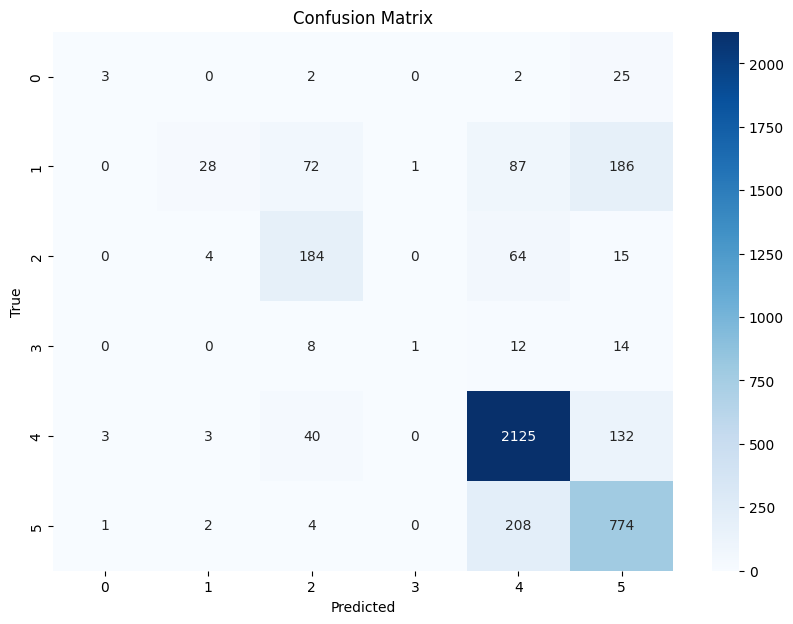

              precision    recall  f1-score   support

           0       0.43      0.09      0.15        32
           1       0.76      0.07      0.14       374
           2       0.59      0.69      0.64       267
           3       0.50      0.03      0.05        35
           4       0.85      0.92      0.89      2303
           5       0.68      0.78      0.73       989

    accuracy                           0.78      4000
   macro avg       0.63      0.43      0.43      4000
weighted avg       0.77      0.78      0.75      4000

0.77875
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [4]:
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
# Get the best estimator
best_model = grid_search.best_estimator_
# model.fit(X_train,y_train)
# Visualize the Confusion Matrix
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print('\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
#model.score(X_test,y_test)
report=classification_report(y_test,y_pred)
print(report)
print(accuracy_score(y_test,y_pred))
# Print the best parameters and score
best_params = grid_search.best_params_
print(best_params)
